In [13]:
using Plots
using DelimitedFiles
using Statistics
using NearestNeighbors
using Roots

# Functions

In [6]:
#k = 1 -> nearest neighbor
function kth_NN(data, k=1)
    N = length(data)
    k_NN::Vector{Int64} = zeros(N)
    
    points = hcat(real(data), imag(data))'
    
    kdtree = KDTree(points)
    idxs, dists = knn(kdtree, points, k+1, true)

    
    for i in 1:N
        k_NN[i] = idxs[i][k+1]
    end
    
    return k_NN
end

# Nearest neighbour of data1 in data2
function find_nearest_neighbors_complex(data1::Vector{<:Complex}, data2::Vector{<:Complex})
    # Convert complex numbers to 2D points (real and imaginary parts as Float64)
    points1 = hcat(real(data1), imag(data1))' .|> Float64   # Each column is a 2D point
    points2 = hcat(real(data2), imag(data2))' .|> Float64

    # Build a KDTree from points2
    tree = KDTree(points2)
    
    nearest_indices = Array{Int64, 1}(undef, length(data1))
    nearest_distances = Array{Float64, 1}(undef, length(data1))

    # For each point in data1, find the nearest neighbor in data2
    for i in 1:length(data1)
        query_point = points1[:, i]
        idx, dist = knn(tree, query_point, 1)  # find the nearest neighbor
        nearest_indices[i] = idx[1]            # store the index of the nearest neighbor
        nearest_distances[i] = dist[1]         # store the distance to the nearest neighbor
    end

    return nearest_indices, nearest_distances
end

Rplus(k, r) = sqrt((1-k)^2*r + k^2)/sqrt(r)

function Rminus(k, r)
    kc = 1/(1 + 1/sqrt(r))

    if k < kc
        return sqrt((1-k)^2*r - k^2)/sqrt(r)
    end

    return 0.0
end

d(k, r) = 0.5*(Rplus(k, r) + Rminus(k, r))
R(k, r) = 0.5*(Rplus(k, r) - Rminus(k, r))


# Area estimation
A_tot(k, r) = pi*( Rplus(k, r)*Rplus(k, r) - Rminus(k, r)*Rminus(k, r) )
A_clusters(k, r, n) = n*pi*R(k, r)*R(k, r)

A(k, r, n) = A_tot(k, r) - A_clusters(k, r, n)

A (generic function with 1 method)

# Generate points

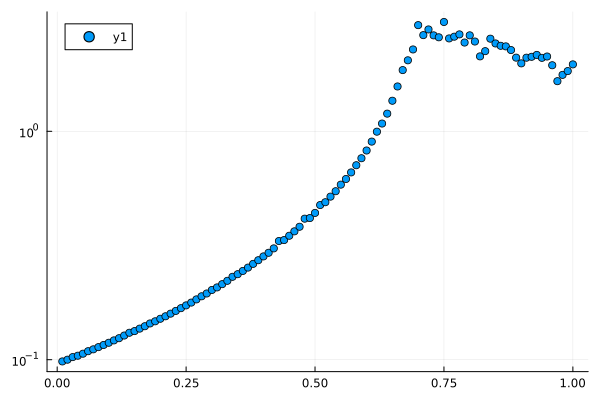

In [15]:
function main()
    L::Int64 = 6
    d::Int64 = 2^L
    r::Int64 = 5

    vec_k = Array(0.01:0.01:1.)
    N::Int64 = length(vec_k)
    
    dir = string("./../files/eig_QFT_L", L, "_r", r, "_v2.dat")
    eigvalues = readdlm(dir, ',', ComplexF64)

    ang_velocity = Array{Float64}(undef, N)
    ang_velocity_err = Array{Float64}(undef, N)
    

    for i in 1:N
    
        k = vec_k[i]
        delta_k = k/1000

        eig_1 = eigvalues[1 + 3*(i-1), :]
        eig_2 = eigvalues[2 + 3*(i-1), :]
        
        eig_1 = filter(ev -> abs(imag(ev)) > 1e-13, eig_1)
        eig_2 = filter(ev -> abs(imag(ev)) > 1e-13, eig_2)
     
        nearest_indices_1, nearest_distances_1 = find_nearest_neighbors_complex(eig_2, eig_1)
        
        eig_1 = angle.(eig_1)
        eig_2 = angle.(eig_2)
        
        slope = Vector{Float64}(undef, length(eig_2))

        for j in 1:length(eig_2)
            slope[j] = abs(eig_1[nearest_indices_1[j]] - eig_2[j]) / delta_k
        end

        ang_velocity[i] = mean(slope)
        ang_velocity_err[i] = std(slope)
        
    end

    pl = scatter(vec_k, ang_velocity, linecolor="blue",  yaxis=:log)
    display(pl)
    
    vec = Array{Float64}(undef, length(vec_k), 3)
    vec[:, 1] = vec_k
    vec[:, 2] = ang_velocity
    vec[:, 3] = ang_velocity_err
    dir = string("./../data/QFT_angle_velocity_L", L, "_r", r, "_v2.dat")
    writedlm(dir, vec, ',')
    
end

main()

# Estimation by area (check exact result)

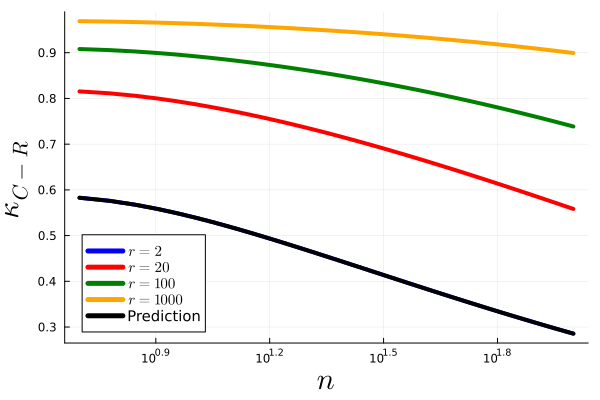

In [8]:
function main()
    L::Int64 = 6
    d::Int64 = 2^L
    n_min::Int64 = 5
    n_max::Int64 = 100
    N::Int64 = n_max - n_min + 1

    vec_r::Array{Int64} = [2, 20, 100, 1000]
    vec_n::Array{Int64} = Array(n_min:1:n_max)
    vec_res::Array{Float64} = Array{Float64}(undef, length(vec_r)+1, N) 


    for i in 1:length(vec_r)
        r = vec_r[i]
        k_R_D = 1/(1 + 1/sqrt(r))
        
        for j in 1:N
            n = vec_n[j]
            x = sqrt( (csc(pi/n) + sin(pi/n)) / 2 )
            k_C_R = 1/(1 + x/sqrt(r))+0.001
            
            g(k) = A(k, r, n)
    
            root = find_zero(g, (k_C_R, k_R_D), Bisection())
    
            vec_res[i, j] = root
        end
    end

    r=2 # change value to change black color overlap
    for j in 1:N

        n = vec_n[j]
        x = sqrt( (csc(pi/n) + sin(pi/n)) / 2 )
        x = sqrt(2 + 0.125*n^2)/sqrt(n)
        vec_res[length(vec_r)+1, j] = 1/(1 + x/(sqrt(r)))
        
    end

    colors = ["blue", "red", "green", "orange", "black"]
    labels = ["\$r = 2\$", "\$r = 20\$", "\$r = 100\$", "\$r = 1000\$", "Prediction"]
    pl = plot(vec_n, vec_res[1, :], linecolor = colors[1], linewidth=4, label = labels[1], xaxis=:log,
        ylabel="\$ \\kappa_{C-R} \$", xlabel="\$ n \$", xguidefontsize=20, yguidefontsize=20, legendfontsize=10, legend=:bottomleft)



    for i in 2:length(vec_r)+1

        plot!(vec_n, vec_res[i, :], linecolor = colors[i], linewidth=4, label = labels[i])
        
    end
    
    display(pl)
    
end

main()